In [1]:
from collections.abc import Sequence

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.maths import compute_centre, compute_normal_from_raw
from histalign.backend.models import (
    Orientation,
    Resolution,
)
from histalign.backend.models.errors import InvalidOrientationError

vedo.settings.default_backend = "vtk"

In [2]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def compute_origin_from_raw(
    centre: Sequence[int], offset: int, orientation: Orientation
) -> np.ndarray:
    if len(centre) != 3:
        raise ValueError(f"Centre should be 3 coordinates. Got {len(centre)}.")

    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise InvalidOrientationError(other)

    return np.array(origin)


def cut_with_plane(plane, origin, normal, height: bool):
    shape = plane.metadata["shape"]

    plane.cut_with_plane(origin=origin, normal=normal, invert=True)

    after = len(plane.points)
    if height:
        after /= shape[1]
    else:
        after /= shape[0]

    if height:
        shape[0] = after
    else:
        shape[1] = after

    print(f"Updating shape to: {shape}")
    plane.metadata["shape"] = shape

[175 159]
[131. 131. -27. 105. -10. 122.]
[ 83.914    178.086    -46.193195 124.19319  -23.491457 135.49146 ]
[ 22.245926  71.92606  108.42398 ]
[ 71.92607  -98.46033   50.558933]
[ -22.245934  -71.926056 -108.42398 ]
[-71.92606  98.46033 -50.55893]
Updating shape to: [175 157]
Updating shape to: [175 157]
Updating shape to: [175 134]
Updating shape to: [118 134]


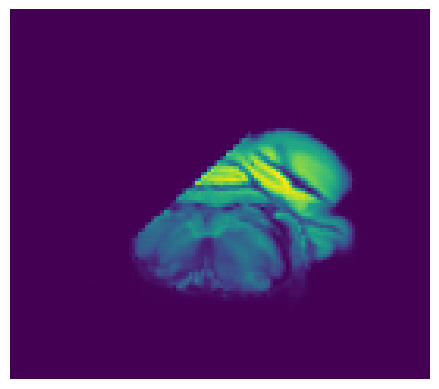

In [3]:
volume = load_volume(get_atlas_path(Resolution.MICRONS_100))

orientation = Orientation.CORONAL
offset = 66
pitch = 25
yaw = 25

origin = compute_origin_from_raw(
    compute_centre(volume.tonumpy().shape), offset, orientation
)
normal = compute_normal_from_raw(pitch, yaw, orientation).tolist()

slice_plane_mesh = volume.slice_plane(origin=origin, normal=normal, autocrop=False)
print(slice_plane_mesh.metadata["shape"])

display_plane = vedo.Plane(
    origin,
    compute_normal_from_raw(0, 0, orientation),
    s=(max(volume.tonumpy().shape),) * 2,
)

print(display_plane.bounds())

display_plane.rotate(pitch, axis=[0, 0, 1], point=origin)
display_plane.rotate(
    yaw,
    axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
    point=origin,
)
display_plane.rotate(
    -pitch,
    axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
    point=origin,
)

print(display_plane.bounds())

normal1 = display_plane.points[0] - display_plane.points[1]
normal2 = display_plane.points[1] - display_plane.points[3]
normal3 = display_plane.points[3] - display_plane.points[2]
normal4 = display_plane.points[2] - display_plane.points[0]

print(normal1)
print(normal2)
print(normal3)
print(normal4)

new_plane = slice_plane_mesh.copy()

cut_with_plane(new_plane, origin + normal1 * 0.5, normal1, height=False)
cut_with_plane(new_plane, origin + normal2 * 0.5, normal2, height=True)
cut_with_plane(new_plane, origin + normal3 * 0.5, normal3, height=False)
cut_with_plane(new_plane, origin + normal4 * 0.5, normal4, height=True)

new_plane_array = new_plane.pointdata["ImageScalars"].reshape(
    new_plane.metadata["shape"]
)
new_plane_array = rotate(new_plane_array, pitch, reshape=False)
imshow(new_plane_array)